# Kaggle Imports
---
Uncomment and run those cells if you're working on Cloud and you need to import the dataset!

- Use this on Colab to import your api json
  

In [265]:
'''
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
'''

mv: cannot stat 'kaggle.json': No such file or directory


- Install Kaggle and import then unzip dataset

In [2]:
'''
!pip install pandas
!pip install kaggle
!kaggle datasets download -d najzeko/steam-reviews-2021
!unzip steam-reviews-2021.zip
'''


100%|██████████████████████████████████████| 2.97G/2.97G [04:29<00:00, 11.0MB/s]
100%|██████████████████████████████████████| 2.97G/2.97G [04:29<00:00, 11.9MB/s]
Archive:  steam-reviews-2021.zip
  inflating: steam_reviews.csv       


  # Libraries and Functions imports

In [36]:
import pandas as pd
import numpy as np        
from datetime import datetime

In [2]:
dataframe = pd.read_csv('./steam_reviews.csv', nrows= 5000000)
print(dataframe.columns)

Index(['Unnamed: 0', 'app_id', 'app_name', 'review_id', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'recommended',
       'votes_helpful', 'votes_funny', 'weighted_vote_score', 'comment_count',
       'steam_purchase', 'received_for_free', 'written_during_early_access',
       'author.steamid', 'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played'],
      dtype='object')


# [RQ2] Let's explore the dataset by finding simple insights into the reviews.
---

### Plot the number of reviews for each application in descending order.

Text(0, 0.5, 'Reviews Amount')

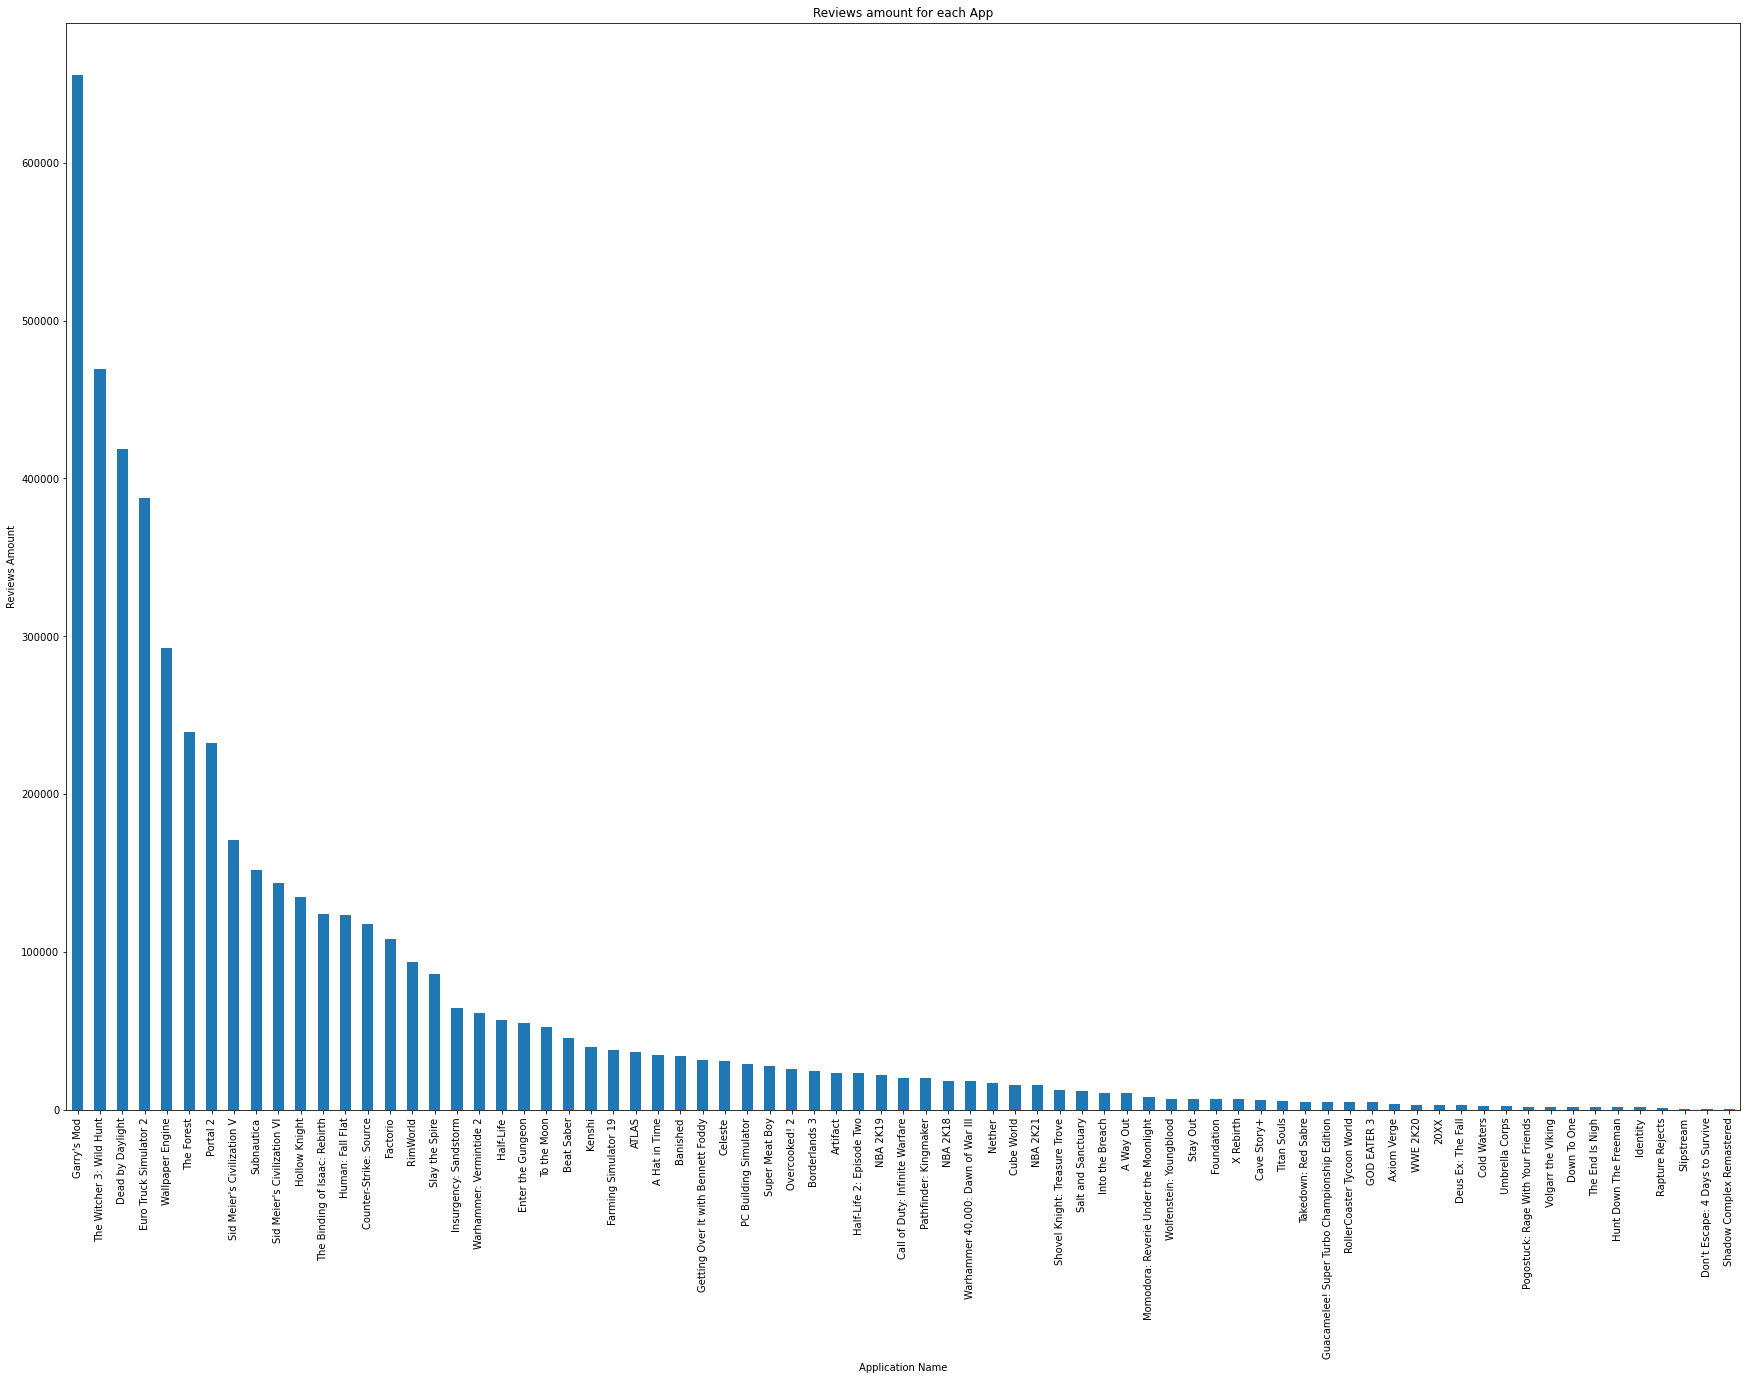

In [3]:
reviewsAmounts = dataframe['app_name'].value_counts()
ra_plot = reviewsAmounts.plot(kind='bar',
                                    figsize=(30,20),
                                    title="Reviews amount for each App")
ra_plot.set_xlabel("Application Name")
ra_plot.set_ylabel("Reviews Amount")
#plt.show()

### Find out are the most and least reviewed applications

In [4]:
print(reviewsAmounts.idxmax())
print(reviewsAmounts.idxmin())

Garry's Mod
Shadow Complex Remastered


### What applications have the best Weighted Vote Score?


In [5]:
# daframe.sort_values('weighted_vote_score')
scores = dataframe['weighted_vote_score']
max = scores.idxmax()

print(dataframe[dataframe['weighted_vote_score'] == dataframe['weighted_vote_score'].max()]['app_name'])


2353895    Subnautica
Name: app_name, dtype: object


### Which applications have the most and the least recommendations?


In [6]:
recommended = dataframe.groupby('app_name')['recommended'].apply(lambda r : (r == True).sum()).reset_index(name = 'recommendations')
max_min_recommendations = recommended[
        (recommended['recommendations'] == recommended['recommendations'].max()) |
        (recommended['recommendations'] == recommended['recommendations'].min())
      ]
print(max_min_recommendations)

       app_name  recommendations
25  Garry's Mod           632558
33     Identity              439


### How many of these applications were purchased, and how many were given for free?


In [7]:
print((dataframe)['received_for_free'].agg({'Given for free' : lambda x : (x == True).sum(), 'Purchased' : lambda y : (y == False).sum()}))

Given for free     137647
Purchased         4862353
Name: received_for_free, dtype: int64


# [RQ3]  Now it's important to understand the preferred time to do reviews.
---


### What is the most common time that authors review an application? For example, authors usually write a review at 17:44.

In [8]:
timeframes = pd.to_datetime(dataframe['timestamp_created'].apply(lambda time : (datetime.fromtimestamp(time))))

In [9]:
modes = timeframes.dt.time.mode()
print("People usually write reviews at: ")
[print(time.strftime('%H:%M') ) for time in modes.values]

People usually write reviews at: 
16:54


[None]

### Create a function that receives as a parameter a list of time intervals and returns the plot the number of reviews for each of the intervals.


In [10]:
# Counting how many datetime occurences in input_timeframes belong to each interval in intervals
#
# Parameters :
# [intervals] : List of datetime tuples (interval_start, interval_end)
# such that they define time intervals. E.G. = (06:00, 12:00). [start] has to be lesser than [end]
# [input_timeframes] : input list of (DateTime objects)
#
# Returns : A Pandas dataframe with input_timeframes grouped by intervals.
#           E.G. : 
#           '    Interval   |   Reviews    '
#           ' --------------|--------------'
#           ' 06:00 - 09:59 |    100000    '
#           ' 10:00 - 11:59 |     30000    '
#           '------------------------------'
def count_reviews_in_belonging_t_interval(intervals, input_timeframes):

    df_timeframes = pd.DataFrame()
    df_timeframes['times'] = input_timeframes
    df_timeframes.index = pd.to_datetime(input_timeframes)
    output = pd.DataFrame({'Interval' : [], 'Reviews' : []})

    for (start,end) in intervals :
        assert(start < end), 'Input Mismatch: DateTime interval had start greater than end!'
        
        start = start.strftime('%H:%M')
        end = end.strftime('%H:%M')
        r_amount = len(df_timeframes.between_time(start, end))
        output = output.append(pd.DataFrame({'Interval' : ['{}-{}'.format(start,end)], 'Reviews': [r_amount]}), ignore_index = True)
    return output


### Use the function that you created in the previous literal to plot the number of reviews between the following time intervals:

<AxesSubplot:xlabel='Interval'>

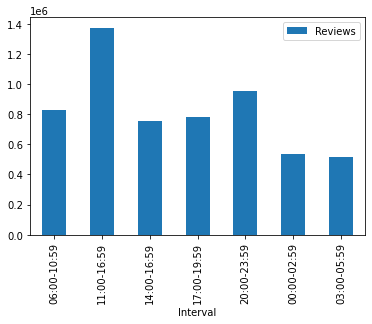

In [11]:
# Defining said intervals as datetime objects
intervals = [
    ( datetime.strptime('06:00:00', "%H:%M:%S"), datetime.strptime('10:59:59', "%H:%M:%S") ),
    ( datetime.strptime('11:00:00', "%H:%M:%S"), datetime.strptime('16:59:59', "%H:%M:%S") ),
    ( datetime.strptime('14:00:00', "%H:%M:%S"), datetime.strptime('16:59:59', "%H:%M:%S") ), 
    ( datetime.strptime('17:00:00', "%H:%M:%S"), datetime.strptime('19:59:59', "%H:%M:%S") ),
    ( datetime.strptime('20:00:00', "%H:%M:%S"), datetime.strptime('23:59:59', "%H:%M:%S") ),
    ( datetime.strptime('00:00:00', "%H:%M:%S"), datetime.strptime('02:59:59', "%H:%M:%S") ),
    ( datetime.strptime('03:00:00', "%H:%M:%S"), datetime.strptime('05:59:59', "%H:%M:%S") )
]

# Counnting how many reviews have been placed in said intervals
output = count_reviews_in_belonging_t_interval(intervals, timeframes)
output.plot(x = 'Interval', y='Reviews', kind='bar')

# [RQ4] As Steam is a worldwide platform, the reviews can be done in many languages. Let's extract some information about it.

### What are the top 3 languages used to review applications?

In [12]:
top_3_languages = dataframe['language'].value_counts()[:3].index.tolist()
print(top_3_languages)

['english', 'schinese', 'russian']


### Create a function that receives as parameters both the name of a data set and a list of languages’ names and returns a data frame filtered only with the reviews written in the provided languages.

In [13]:
def filter_dataset_on_languages(dataset, languages) :
    return dataset[dataset['language'].isin(languages)]


### Use the function created in the previous literal to find what percentage of these reviews (associated with the top 3 languages) were voted as funny?

In [14]:
filtered_ds = filter_dataset_on_languages(dataframe, top_3_languages)

In [15]:
print('{:.2f}%'.format(100 * (len(filtered_ds[filtered_ds['votes_funny'] > 0])) / len(filtered_ds)))

11.99%


### Use the function created in the literal “a” to find what percentage of these reviews (associated with the top 3 languages) were voted as helpful?

In [16]:
print('{:.2f}%'.format(100 * (len(filtered_ds[filtered_ds['votes_helpful'] > 0])) / len(filtered_ds)))

28.50%


# [RQ5] The reviews' authors are users from the game that provide their opinion on it. Now you can check how often they make reviews.



### Plot the top 10 most popular reviewers and the number of reviews.

In [17]:
top_10_reviewers = dataframe[dataframe['author.steamid'].isin(dataframe['author.steamid'].value_counts()[:10].index.tolist())][['author.steamid','author.num_reviews']].drop_duplicates()

<AxesSubplot:xlabel='Reviewer'>

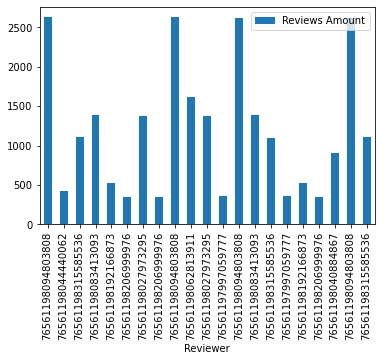

In [18]:
reviewers = pd.DataFrame({'Reviewer':top_10_reviewers['author.steamid'], 'Reviews Amount':top_10_reviewers['author.num_reviews']})
reviewers.plot(x = 'Reviewer', y = 'Reviews Amount', kind='bar')


### What applications did the most popular author review?

In [19]:
most_popular_author = dataframe['author.steamid'].mode()[0]
most_popular_author_reviews = dataframe[dataframe['author.steamid'] == most_popular_author]


In [20]:
print(most_popular_author_reviews[['app_id','app_name']])

         app_id                            app_name
512675       70                           Half-Life
539037      240              Counter-Strike: Source
658130      420            Half-Life 2: Episode Two
849477      620                            Portal 2
1549581    4000                         Garry's Mod
1728583    8930          Sid Meier's Civilization V
2141495  381210                    Dead by Daylight
2252905  289070         Sid Meier's Civilization VI
2392987  264710                          Subnautica
2571139  477160                    Human: Fall Flat
2646056  242920                            Banished
2682381  504230                             Celeste
2708381  240720  Getting Over It with Bennett Foddy
2743294  253230                       A Hat in Time
2913786  242760                          The Forest
3289384  332200                         Axiom Verge
3393685  250900       The Binding of Isaac: Rebirth
3470835  206440                         To the Moon
3474508  200

### How many applications did he purchase, and how many did he get as free? Provide the number (count) and the percentage.

In [21]:
games_received_for_free = most_popular_author_reviews[most_popular_author_reviews['received_for_free'] == True]
games_paid = most_popular_author_reviews[most_popular_author_reviews['received_for_free'] == False]

amount_paid = len(games_paid)
amount_free = len(games_received_for_free)
tot = amount_free + amount_paid

print("Most popular reviewer has : ")
print("{}/{} ({:.2f}%) games that have been purchased".format(amount_paid, tot, 100 * amount_paid / tot))
print("{}/{} ({:.2f}%) games that have been received for free".format(amount_free, tot, 100 * amount_free / tot))

Most popular reviewer has : 
34/35 (97.14%) games that have been purchased
1/35 (2.86%) games that have been received for free


### How many of the applications he purchased reviewed positively, and how many negatively? How about the applications he received for free?

In [22]:
print("Author {} has reviewed positively {} of the {} purchased.".format(most_popular_author, len(games_paid[games_paid['recommended'] == True]), amount_paid))
print("Author {} has reviewed negatively {} of the {} purchased.".format(most_popular_author, len(games_paid[games_paid['recommended'] == False]), amount_paid))
print("Author {} has reviewed positively {} of the {} purchased.".format(most_popular_author, len(games_received_for_free[games_received_for_free['recommended'] == True]), amount_free))
print("Author {} has reviewed negatively {} of the {} purchased.".format(most_popular_author, len(games_received_for_free[games_received_for_free['recommended'] == False]), amount_free))

Author 76561198062813911 has reviewed positively 34 of the 34 purchased.
Author 76561198062813911 has reviewed negatively 0 of the 34 purchased.
Author 76561198062813911 has reviewed positively 1 of the 1 purchased.
Author 76561198062813911 has reviewed negatively 0 of the 1 purchased.


# [RQ6] It's time to get information from the updates that a user does to his reviews.
---

### What is the average time (days and minutes) a user lets pass before he updates a review?

In [23]:
# Filtering out reviews that don't have updated timestamp
updated_reviews = dataframe[dataframe['timestamp_updated'].notnull()]
updated_reviews = updated_reviews[updated_reviews['timestamp_updated'] != updated_reviews['timestamp_created']]

In [25]:
time_between_updates = updated_reviews.apply(lambda row : (datetime.fromtimestamp(row['timestamp_updated']) - datetime.fromtimestamp(row['timestamp_created'])), axis=1)

In [48]:
average_time_between_updates = np.mean(time_between_updates)
print(average_time_between_updates)

369 days 15:49:46.837960392


### Plot the top 3 authors that usually update their reviews.

<AxesSubplot:title={'center':'Top 3 Review Updaters'}, xlabel='Reviewers', ylabel='Updates Amount'>

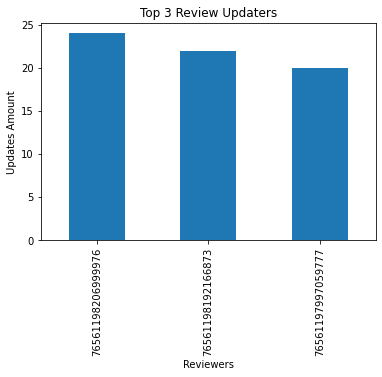

In [60]:
most_frequent_updaters = (updated_reviews['author.steamid'].value_counts()[:3])
most_frequent_updaters.plot(kind='bar', title ="Top 3 Review Updaters", xlabel="Reviewers", ylabel ="Updates Amount")